Implement autoencoder with 1 hidden layer

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import save_npz, load_npz

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
from keras.optimizers import SGD

Using TensorFlow backend.


In [3]:
# setup 
batch_size = 128 
epochs = 20 
penalty = 0.001


# load data 
os.chdir(r'/home/qshan/Desktop/Repos/Big_Data_Projects/Recommender_System/Matrix_Factorization')
A = load_npz('A_train.npz')
A_test = load_npz('A_test.npz')
mask = (A > 0) * 1.0 
mask_test = (A_test > 0) * 1.0

In [19]:
# make copies since we will shuffle
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

N, M = A.shape
print("N:", N, "M:", M)
print("n_batches:", N // batch_size + 1)

N: 10000 M: 2000
n_batches: 79


In [20]:
# overall mean to centralize the ratings 
mu = A.sum() / mask.sum()
print('Overall mean: ', mu)

Overall mean:  3.4480663572591004


In [21]:
# build autoencoder model with 1 hidden layer 

i = Input(shape = (M, ))

# dropout regularization
x = Dropout(0.7)(i)

# l2 norm regularization
x = Dense(700, activation = 'tanh', kernel_regularizer = l2(penalty))(x)
# output 
x = Dense(M, kernel_regularizer = l2(penalty))(x)

In [22]:
# redefine loss function to exclude the missing ratings 
def loss_mse(y_true, y_pred):
    # cast boolean array to 00110011...
    mask = K.cast(K.not_equal(y_true, 0), dtype = 'float32')
    residual = y_pred - y_true
    # only account for the ratings nonzero (nonmissing)
    sqdiff = residual * residual * mask 
    sse = K.sum(K.sum(sqdiff))
    n = K.sum(K.sum(mask))
    return sse / n 

In [26]:
def train_generator(A, mask):
    while True:
        # shuffle the data for each epoch
        A, mask = shuffle(A, mask)
        n_batches = A.shape[0] // batch_size + 1 
        for i in range(n_batches):
            upper_limit = min((i + 1) * batch_size, A.shape[0])
            a = A[i * batch_size : upper_limit].toarray()
            m = mask[i * batch_size : upper_limit].toarray()
            # center the data, and keep 0s (missing) as there are 
            a = a - mu * m
            yield a, a 
    
def test_generator(A, mask, A_test, mask_test):
    n_batches = A.shape[0] // batch_size + 1 
    while True:
        # don't shuffle, just use the current batch
        for i in range(n_batches):
            # note that here i is also ordered by user id, so A[i] and A_test[i] are refering the same user
            upper_limit = min( (i + 1) * batch_size, A.shape[0])
            a = A[i * batch_size : upper_limit].toarray()
            m = mask[i * batch_size :upper_limit].toarray()
            a_test = A_test[i * batch_size : upper_limit].toarray()
            m_test = mask_test[i * batch_size : upper_limit].toarray()
            a = a - mu * m 
            a_test = a_test - mu * m_test 
            # return input (from train) and targets (from test) 
            yield a, a_test 

In [27]:
# model 
model = Model(i, x)
model.compile(loss = loss_mse, optimizer = SGD(lr = 0.08, momentum = 0.9), metrics = [loss_mse])

r = model.fit_generator(train_generator(A, mask), 
                       validation_data = test_generator(A_copy, mask_copy, A_test, mask_test),
                       epochs = epochs, steps_per_epoch = A.shape[0] // batch_size + 1,
                       validation_steps = A_test.shape[0] // batch_size + 1)
print(r.history.keys())

Epoch 1/20
79/79 [==============================] - 15s 195ms/step - loss: 1.8152 - loss_mse: 0.6611 - val_loss: 1.6520 - val_loss_mse: 0.6402
Epoch 2/20
79/79 [==============================] - 18s 230ms/step - loss: 1.5188 - loss_mse: 0.6252 - val_loss: 1.4078 - val_loss_mse: 0.6245
Epoch 3/20
79/79 [==============================] - 21s 267ms/step - loss: 1.2952 - loss_mse: 0.6006 - val_loss: 1.2258 - val_loss_mse: 0.6141
Epoch 4/20
79/79 [==============================] - 21s 263ms/step - loss: 1.1328 - loss_mse: 0.5879 - val_loss: 1.0898 - val_loss_mse: 0.6075
Epoch 5/20
79/79 [==============================] - 20s 253ms/step - loss: 1.0092 - loss_mse: 0.5774 - val_loss: 0.9873 - val_loss_mse: 0.6028
Epoch 6/20
79/79 [==============================] - 19s 246ms/step - loss: 0.9178 - loss_mse: 0.5718 - val_loss: 0.9097 - val_loss_mse: 0.5996
Epoch 7/20
79/79 [==============================] - 17s 210ms/step - loss: 0.8507 - loss_mse: 0.5698 - val_loss: 0.8503 - val_loss_mse: 0.5969

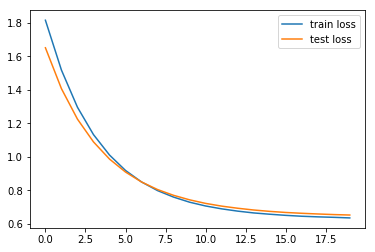

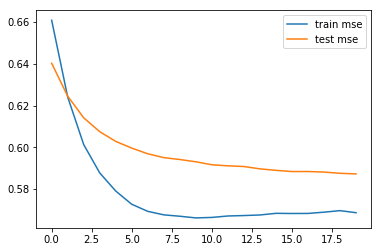

In [29]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['loss_mse'], label="train mse")
plt.plot(r.history['val_loss_mse'], label="test mse")
plt.legend()
plt.show()